<center> <h1> **Fraud Detection**</h1> <br>
<h2>
BankSim is an agent-based simulator of bank payments based on a sample of aggregated transactional data that can be used for fraud detection research.</h2></center><br> 	
<h3>
Statistical and a Social Network Analysis (SNA) of relations between merchants and customers were used
to develop and calibrate the model. Our ultimate goal is for BankSim to be usable to model relevant scenarios that combine normal payments and injected known fraud signatures. The data sets generated by BankSim contain no personal information or disclosure of legal and private customer transactions.We argue that BankSim generates data that usefully approximates the relevant aspects of the real data.
</h3>

###<center>We ran BankSim for 180 steps (approx. six months), and we injected thieves that aim to steal an average of three cards per step and perform about two fraudulent transactions per day. We produced 594643 records in total. Where 587443 are normal payments and 7200 fraudulent transactions. Since this is a randomised simulation the values are of course not identical to original data.</center>

###Import & Setup

In [ ]:
pip install scikit-plot

In [ ]:
import numpy as np
import scipy.stats as stats
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.cluster import DBSCAN 
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import itertools
import time
from warnings import filterwarnings
from sklearn import ensemble
from scipy.stats import zscore

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x) #prevent numpy exponential 
                                   #notation on print, default False
# filterwarnings('ignore')

In [ ]:
#import csv files from the Google Storage Database
fraud_df = pd.read_csv('https://storage.googleapis.com/datasets_for_analysis/Fraud_detection_3.csv', index_col = False, error_bad_lines=False)

In [ ]:
fraud_df.rename(columns={'step':'day_counter'}, inplace=True)

In [ ]:
fraud_df.drop(columns=['customer', 'merchant'], inplace=True)

In [ ]:
fraud_df.head()

day_counter  age gender  ...             category amount fraud
0            0  '4'    'M'  ...  'es_transportation'   4.55     0
1            0  '2'    'M'  ...  'es_transportation'  39.68     0
2            0  '4'    'F'  ...  'es_transportation'  26.89     0
3            0  '3'    'M'  ...  'es_transportation'  17.25     0
4            0  '5'    'M'  ...  'es_transportation'  35.72     0

[5 rows x 8 columns]

In [ ]:
print('The shape of the dataset is: {}'.format(fraud_df.shape))

The shape of the dataset is: (594643, 8)


#Exploratory Data Analysis

In [ ]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF_train = fraud_df[fraud_df.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF_train)

#Check for null values
print(fraud_df.isnull().sum())

Duplicate Rows except first occurrence based on all columns are :
        day_counter  age gender  ...             category amount fraud
406               0  '2'    'F'  ...  'es_transportation'  17.37     0
451               0  '1'    'M'  ...  'es_transportation'   1.51     0
485               0  '2'    'F'  ...  'es_transportation'  10.09     0
502               0  '3'    'M'  ...  'es_transportation'  16.10     0
568               0  '3'    'F'  ...  'es_transportation'  37.29     0
...             ...  ...    ...  ...                  ...    ...   ...
594609          179  '3'    'M'  ...  'es_transportation'   4.23     0
594617          179  '2'    'F'  ...  'es_transportation'  23.40     0
594620          179  '3'    'F'  ...  'es_transportation'   4.75     0
594629          179  '4'    'M'  ...  'es_transportation'  29.37     0
594642          179  '4'    'F'  ...  'es_transportation'  26.93     0

[12999 rows x 8 columns]
day_counter    0
age            0
gender         0
zipco

In [ ]:
#Lets transform this column so that we can do some simple math
fraud_df['fraud'].astype(str).astype(int)

gender = fraud_df['gender'].copy()
#purchase_categories = pd.get_dummies(fraud_df.category, drop_first=True)

#Determine how much of the data is fraud vs normal transactions
fraud_explore = fraud_df[fraud_df['fraud'] == 1]
fraud_explore =  fraud_explore.shape[0]
normal_explore = fraud_df[fraud_df['fraud'] == 0]
normal_explore = normal_explore.shape[0]
print('The amount of fraudulent transactions in the dataset are: {}'.format(fraud_explore))
print('The amount of normal transactions in the dataset are: {}'.format(normal_explore))
print('The percentage of fraud in our training data is: {:.2f} %' .format(fraud_explore/normal_explore))

The amount of fraudulent transactions in the dataset are: 7200
The amount of normal transactions in the dataset are: 587443
The percentage of fraud in our training data is: 0.01 %


In [ ]:
fraud_df

day_counter  age gender  ...             category amount fraud
0                 0  '4'    'M'  ...  'es_transportation'   4.55     0
1                 0  '2'    'M'  ...  'es_transportation'  39.68     0
2                 0  '4'    'F'  ...  'es_transportation'  26.89     0
3                 0  '3'    'M'  ...  'es_transportation'  17.25     0
4                 0  '5'    'M'  ...  'es_transportation'  35.72     0
...             ...  ...    ...  ...                  ...    ...   ...
594638          179  '3'    'F'  ...  'es_transportation'  20.53     0
594639          179  '4'    'F'  ...  'es_transportation'  50.73     0
594640          179  '2'    'F'  ...         'es_fashion'  22.44     0
594641          179  '5'    'M'  ...  'es_transportation'  14.46     0
594642          179  '4'    'F'  ...  'es_transportation'  26.93     0

[594643 rows x 8 columns]

In [ ]:
import matplotlib.pyplot as plt

#Lets transform this back so that we can plot it
fraud_df['fraud'].astype(str).astype(object)

#Switch the column datatype back to object in order to call the hist function
fraud_explore = fraud_df[fraud_df['fraud'] == 1]
normal_explore = fraud_df[fraud_df['fraud'] == 0]

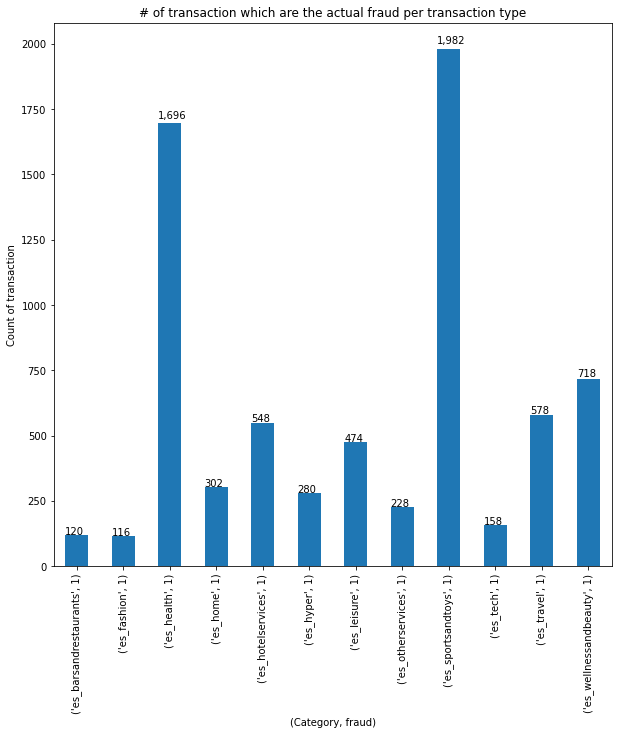

In [ ]:
#This will show us all of the normal transactions in their respective categories
plt.figure(figsize=[10,10])
ax = fraud_explore.groupby(['category', 'fraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Category, fraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

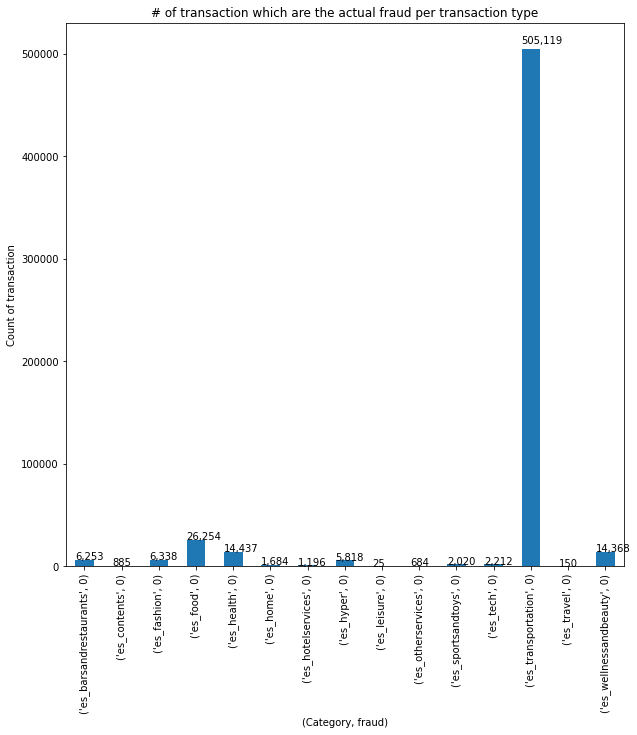

In [ ]:
#This will show us all of the normal transactions in their respective categories
plt.figure(figsize=[10,10])
ax = normal_explore.groupby(['category', 'fraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Category, fraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

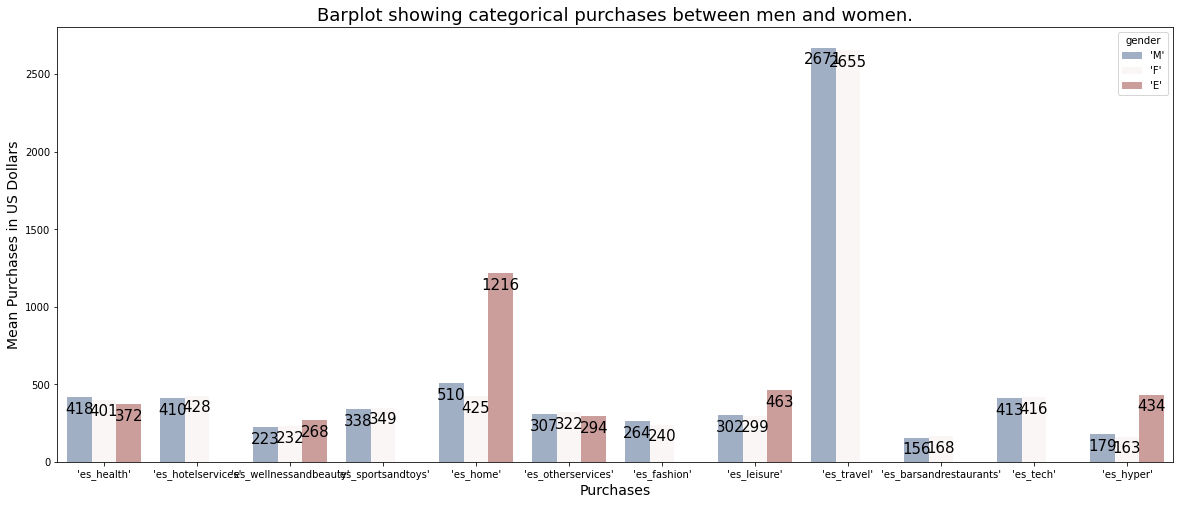

In [ ]:

plt.figure(figsize=(20, 8))
splot=sns.barplot(x="category", y="amount", hue="gender", palette="vlag", ci=None, data=fraud_explore)
plt.ylabel("Mean Purchases in US Dollars", size=14)
plt.xlabel("Purchases", size=14)
plt.title("Barplot showing categorical purchases between men and women.", size=18)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.savefig('Categorical ',dpi=150)

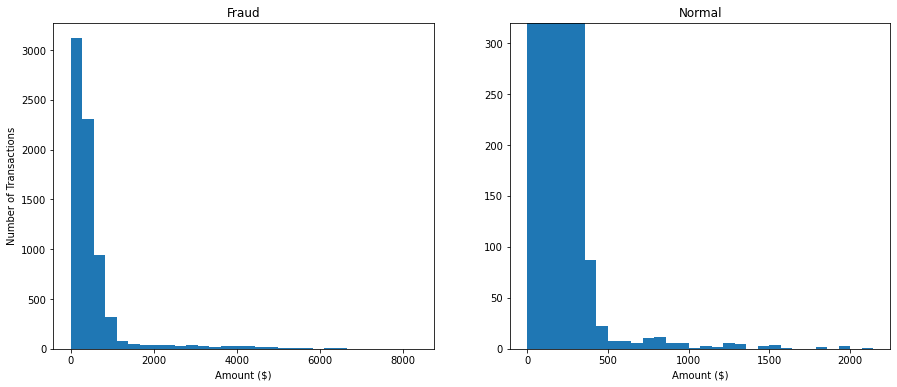

In [ ]:
# amount comparison - How different is the amount of money used in different transaction classes?
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
bins = 30

ax1.hist(fraud_explore['amount'], bins=bins)
ax2.hist(normal_explore['amount'], bins=bins)

ax1.set_title('Fraud')
ax2.set_title('Normal')

ax1.set_xlabel('Amount ($)')
ax2.set_xlabel('Amount ($)')
ax1.set_ylabel('Number of Transactions')

ax2.set_ylim(0, 320)
plt.show()

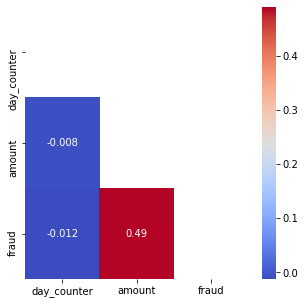

In [ ]:
#Overall which variable or variables seem to have stronger relationship with the target variable?
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corm = fraud_df.corr()
masko = np.zeros_like(corm, dtype = np.bool)
masko[np.triu_indices_from(masko)] = True
masko[np.triu_indices_from(masko)] = True

fig, ax = plt.subplots(figsize = (5,5))
sns.heatmap(corm, mask = masko, cmap = 'coolwarm', annot=True)

#Target Feature Split

In [ ]:
#feature dataset comprises of usable columns other than target column
features = fraud_df[['age','gender','zipcodeOri', 'zipMerchant', 'category', 'amount']].copy()
features_2 = fraud_df[['amount', 'gender']].copy()
#target dataset contains the data to be predicted
target = fraud_df[['fraud']].copy()

In [ ]:
#Get dummies
features_gender = pd.get_dummies(features_2.gender, prefix='gender', drop_first=True)

In [ ]:
#Create a way to separate values not associated with male or female
features_gender.drop(features_gender.columns[2], axis=1, inplace=True)
features_gender.drop(features_gender.columns[0], axis=1, inplace=True)

In [ ]:
#Combine the two arrays
features_2.reset_index(drop=True, inplace=True)
features_gender.reset_index(drop=True, inplace=True)
features_2 = pd.concat([features_2, features_gender], axis=1, sort=False)
features_2.reset_index(drop=True, inplace=True)

In [ ]:
features_2.drop(columns='gender', inplace=True)
#prepare this df for the t-SNE w/ KNN
fraud_days = fraud_df['day_counter']
features_2.reset_index(drop=True, inplace=True)
fraud_days.reset_index(drop=True, inplace=True)
features_days = pd.concat([features_2, fraud_days], axis=1, sort=False)
features_days.reset_index(drop=True, inplace=True)
features_days.rename(columns={features_days.columns[1]: 'is_male'}, inplace=True)
features_days.head(100)

amount  is_male  day_counter
0     4.55        1            0
1    39.68        1            0
2    26.89        0            0
3    17.25        1            0
4    35.72        1            0
..     ...      ...          ...
95   20.73        1            0
96   68.17        0            0
97   34.75        0            0
98  171.07        0            0
99   50.31        0            0

[100 rows x 3 columns]

In [ ]:
#First create a copy of your dataframe
scaled_features = features_days.copy()

#ONLY SCALE the amount column
col_names = ['amount']
features_2 = scaled_features[col_names]
scaler = StandardScaler().fit(features_2.values)
features_2 = scaler.transform(features_2.values)

#Now create a new df
scaled_features[col_names] = features_2
print(scaled_features)

        amount  is_male  day_counter
0        -0.30        1            0
1         0.02        1            0
2        -0.10        0            0
3        -0.19        1            0
4        -0.02        1            0
...        ...      ...          ...
594638   -0.16        0          179
594639    0.12        0          179
594640   -0.14        0          179
594641   -0.21        1          179
594642   -0.10        0          179

[594643 rows x 3 columns]


*This shows the purchase distribution between males and females.*




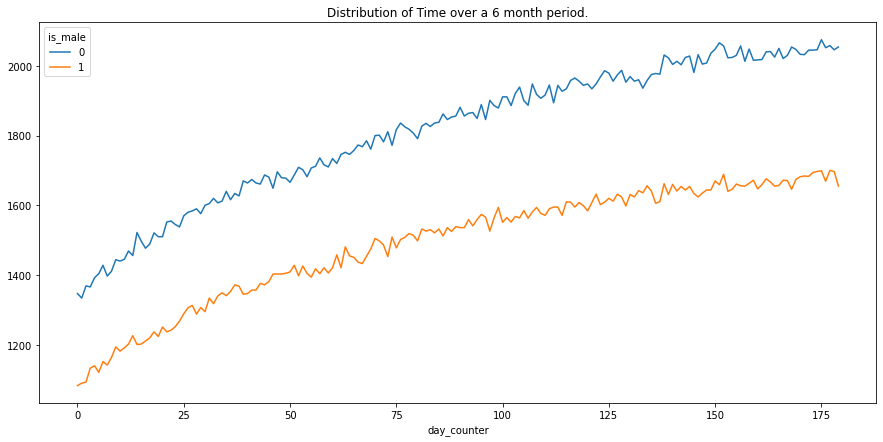

In [ ]:
import matplotlib.dates as md
'''
#visualizations of time and amount
plt.figure(figsize=(10,8))

'''
# plot data
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Distribution of Time over a 6 month period.')
# use unstack()
features_days.groupby(['day_counter', 'is_male']).count()['amount'].unstack().plot(ax=ax)
print('*This shows the purchase distribution between males and females.*')
print('\n')

###Set up undersampling

In [ ]:
# Class count
count_class_0, count_class_1 = target.value_counts()

# Divide by class
df_class_0 = target[target['fraud'] == 0]
df_class_1 = target[target['fraud'] == 1]

df_class_0 = df_class_0[:1000]
df_class_1 = df_class_1[:15000]

#df_class_0_under = df_class_0.sample(count_class_1)
target_10000 = pd.concat([df_class_0, df_class_1], axis=0)

print('Random under-sampling :')
print(target_10000.fraud.value_counts())

Random under-sampling :
1    7200
0    1000
Name: fraud, dtype: int64


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
#create the specs for the column transformer
#the function "make_column_transformer" will create the column transformer object
#categories="auto" and drop="first" tell the encoder to create k-1 columns, rather than k columns
# and that the first category will be the implicit category
preprocess = make_column_transformer(
    (StandardScaler(), ['amount']),
    (OneHotEncoder(categories="auto",drop="first"), ['age','gender','zipcodeOri', 'zipMerchant', 'category'])
)

#fit_transform is the function that fits the transformations to the data and then does the transformation
X_main = preprocess.fit_transform(features)
X = X_main
y_main = np.array(target_10000)
y = y_main

In [ ]:

#reduce the data to first 20K for faster processing
X = X_main[:10000].toarray()

# scale target dataset
y_main = np.array(target)
#reduce the dataset to first 20K for faster processing
y = y_main[:10000]

X.shape

(10000, 25)

In [ ]:
from sklearn.decomposition import PCA
# intialize pca
pca = PCA(n_components=2)

# fit and transform data
X_pca = pca.fit_transform(X)

#Setup of Train/Test Data

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, shuffle=True, random_state=32)

###Random Forest w/ PCA

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(random_state=32)
model1.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [ ]:
print ('Train Data Score : ' ,model1.score(X_train, y_train))

Train Data Score :  1.0


In [ ]:
print ('Test Data Score : ', model1.score(X_test, y_test))

Test Data Score :  0.9915151515151515


Text(0.5, 1.0, 'Test Data Confusion Matrix - PCA')

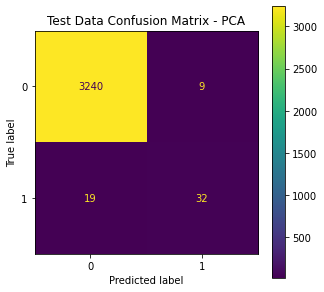

In [ ]:
#plot confusion matrix
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(model1, X_test, y_test, normalize=None, values_format = '.0f')
plt.title('Test Data Confusion Matrix - PCA')

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# generate perfomance report with f1 score, precision, accuracy  and recall parameters
print ('Test Data Perfomance Details')
y_pred = model1.predict(X_test)
xgbclf_acc_score_base = accuracy_score(y_test, y_pred)
print (classification_report(y_test, y_pred))

Test Data Perfomance Details
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3249
           1       0.78      0.63      0.70        51

    accuracy                           0.99      3300
   macro avg       0.89      0.81      0.85      3300
weighted avg       0.99      0.99      0.99      3300



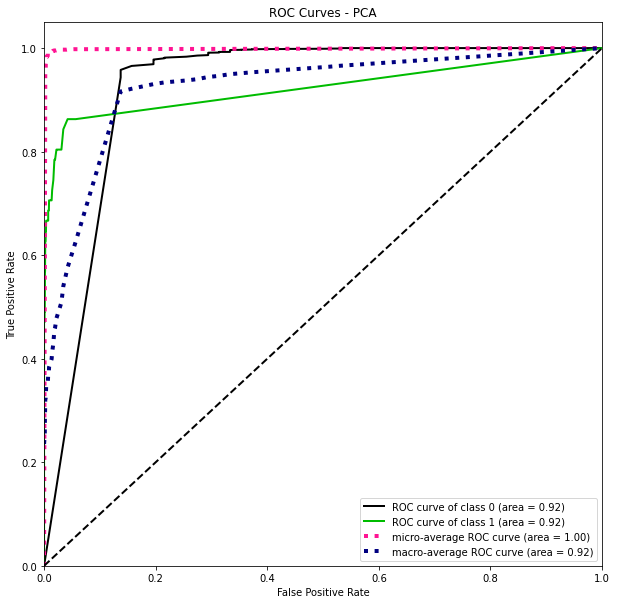

In [ ]:
import scikitplot as skplt

#plot roc curve for test data
y_true = y_test
y_probas = model1.predict_proba(X_test)
plt.rcParams["figure.figsize"] = (10,10)
F.metrics.plot_roc(y_true, y_probas)
plt.title('ROC Curves - PCA')
plt.show()

### Dimensionality Reduction Using T-SNE


In [ ]:
from sklearn.manifold import TSNE

# intialize t-sne
tsne = TSNE(random_state=32)

# fit and transform data
X_tsne = tsne.fit_transform(X)

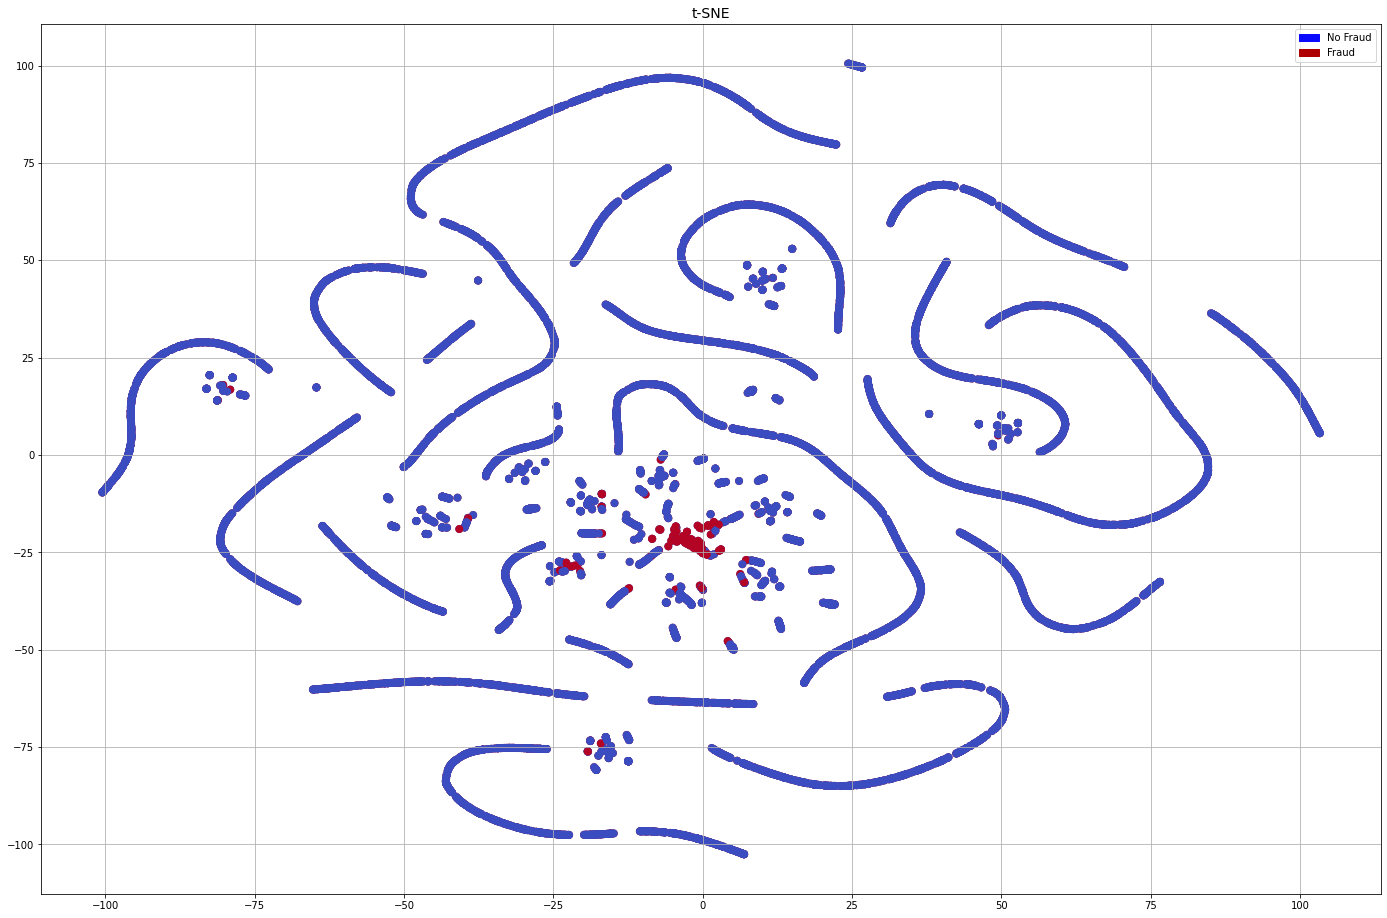

In [ ]:
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

In [ ]:
#Trying to pd.concat 'target' with 'scaled_features' causes all null values for the target column, 
# so this is a work around
temp_df = pd.concat([target, features_gender], axis=1, sort=False)
temp_df.rename(columns={temp_df.columns[1]: 'is_male'}, inplace=True)

In [ ]:
tsne = TSNE(n_components=3, verbose=1, perplexity=50, n_iter=500, learning_rate=200)
tsne_scale_results = tsne.fit_transform(X)
tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.080s...
[t-SNE] Computed neighbors for 10000 samples in 1.817s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.009273
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.601398
[t-SNE] KL divergence after 500 iterations: 0.387160


##K-means w/ t-SNE

Text(0, 0.5, 'Inertia')

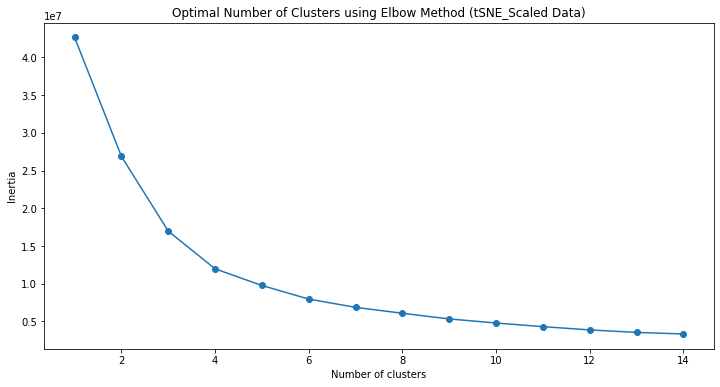

In [ ]:
from sklearn.cluster import KMeans
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(X_tsne)
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

###Kmeans w/ t-SNE Silhouette score

In [ ]:
from sklearn.metrics import silhouette_score

kmeans_tsne_scale = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df_scale)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df_scale, kmeans_tsne_scale.labels_, metric='euclidean')))
labels_tsne_scale = kmeans_tsne_scale.labels_
clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

KMeans tSNE Scaled Silhouette Score: 0.2680782675743103


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


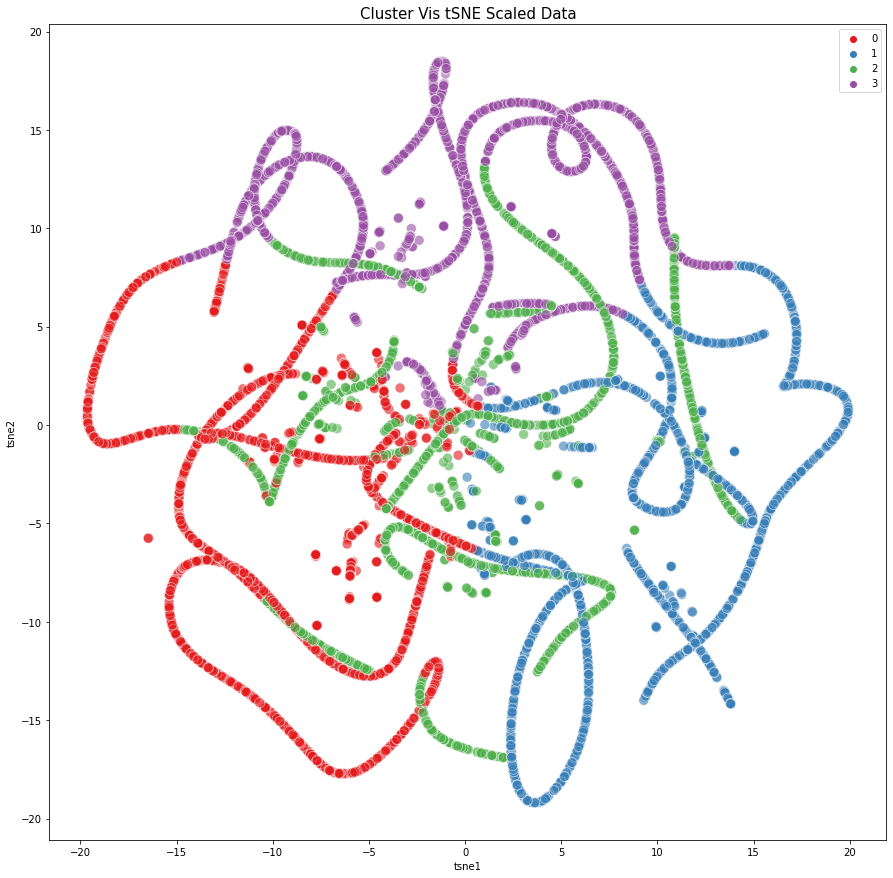

In [ ]:
plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE Scaled Data', fontsize=15)
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objs as go

Scene = dict(xaxis = dict(title  = 'tsne1'),yaxis = dict(title  = 'tsne2'),zaxis = dict(title  = 'tsne3'))
labels = labels_tsne_scale
trace = go.Scatter3d(x=clusters_tsne_scale.iloc[:,0], y=clusters_tsne_scale.iloc[:,2], z=clusters_tsne_scale.iloc[:,1], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'yellow',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [ ]:
#train model with cv of 10
cv_scores = cross_val_score(kmeans_tsne_scale, X_test, y_test, cv=10)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[-15279.7734375  -16441.76171875 -14818.65136719 -16344.83398438
 -16938.61523438 -15468.41992188 -14520.83007812 -16935.52539062
 -15043.63867188 -15644.45996094]
cv_scores mean:-15743.6509765625


In [ ]:
#print shape of dimension reduced feature data
X_tsne.shape

(10000, 2)

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.33, shuffle=True, random_state=32)

### Dimensionality Reduction Using UMAP


In [ ]:
# intialize umap reducer
reducer = umap.UMAP(n_neighbors=5,
                      min_dist=0.3, 
                      metric='correlation', random_state=32)

# fit and transform data
X_umap = reducer.fit_transform(X)

time_start = time.time()

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 4.8160552978515625e-05 seconds


In [ ]:
plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(X_umap.shape[0]):
    plt.text(X_umap[i, 0], X_umap[i, 1], y[i],
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



###Train Test Split UMAP

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_umap, y, test_size=0.33, shuffle=True, random_state=32)

##Random Forest model

In [ ]:
model3 = RandomForestClassifier(random_state=32)
model3.fit(X_umap, y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [ ]:
print ('Train Data Score : ' ,model3.score(X_umap, y))

Train Data Score :  1.0


In [ ]:
print ('Test Data Score : ' ,model3.score(X_umap, y))

Test Data Score :  1.0


Text(0.5, 1.0, 'Test Data Confusion Matrix - UMAP')

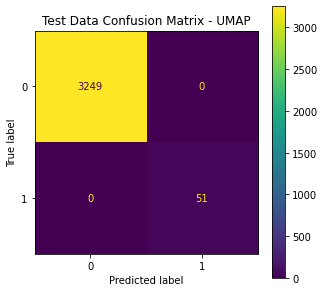

In [ ]:
#plot confusion matrix
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(model3, X_test, y_test, normalize=None, values_format = '.0f')
plt.title('Test Data Confusion Matrix - UMAP')

In [ ]:
# generate perfomance report with f1 score, precision, accuracy  and recall parameters
print ('Test Data Perfomance Details')
y_pred = model3.predict(X_test)
xgbclf_acc_score_base = accuracy_score(y_test, y_pred)
print (classification_report(y_test, y_pred))

Test Data Perfomance Details
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3249
           1       1.00      1.00      1.00        51

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [ ]:
#train model with cv of 10
cv_scores = cross_val_score(model3, X_test, y_test, cv=10)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))
print(cv_scores)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/s

cv_scores mean:0.9906060606060606
[0.98787879 0.99393939 0.99090909 0.99090909 0.99393939 0.98787879
 0.99393939 0.99090909 0.98787879 0.98787879]


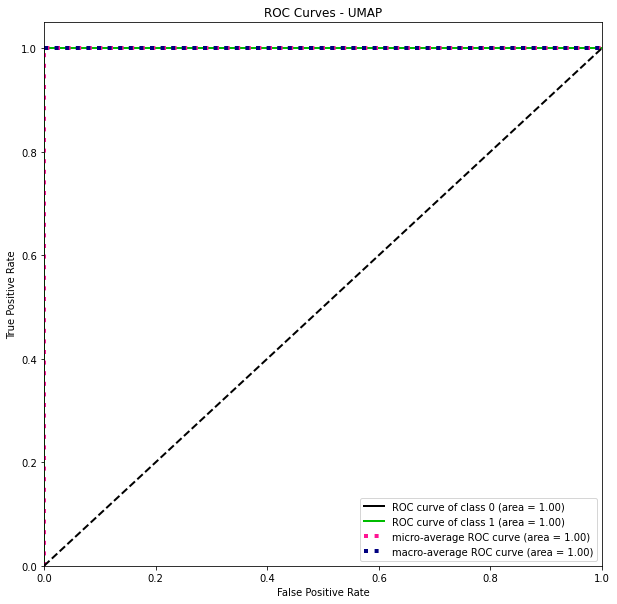

In [ ]:
y_true = y_test
y_probas = model3.predict_proba(X_test)
plt.rcParams["figure.figsize"] = (10,10)
skplt.metrics.plot_roc(y_true, y_probas)
plt.title('ROC Curves - UMAP')
plt.show()

###Among all three, the dimensionality reduction, random forest with PCA yeilded the highest accuracy score.


## Customer Segmentation using Clustering

In [ ]:
#create the specs for the column transformer
#the function "make_column_transformer" will create the column transformer object
#categories="auto" and drop="first" tell the encoder to create k-1 columns, rather than k columns
# and that the first category will be the implicit category
preprocess = make_column_transformer(
    (StandardScaler(), ['amount']),
    (OneHotEncoder(categories="auto",drop="first"), ['age','gender','zipcodeOri', 'zipMerchant', 'category'])
)

#fit_transform is the function that fits the transformations to the data and then does the transformation
processed_data = preprocess.fit_transform(fraud_df)
#reduce the data to 10K for faster processing
processed_data = processed_data[:10000].toarray()

DBSCAN Model

In [ ]:
#define DBSCAN
#use dimensionally reduced data
db = DBSCAN().fit(X_pca) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ 

In [ ]:
# Number of clusters in labels, ignoring noise if present. 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
#print the number of clusters
n_clusters_

5

['g', 'y', 'r', 'blue', 'violet']


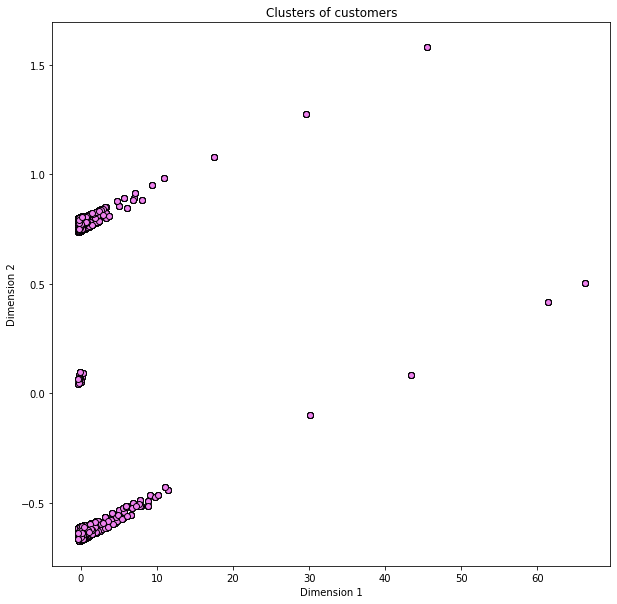

In [ ]:
# Plot result 
import matplotlib.pyplot as plt 
  
# Black removed and is used for noise instead. 
plt.rcParams["figure.figsize"] = (10,10)
unique_labels = set(labels) 
colors = ['g', 'y' , 'r', 'blue', 'violet'] 
print(colors) 
for k, col in zip(unique_labels, colors): 
    if k == -1: 
        # Black used for noise. 
        col = 'k'
  
    class_member_mask = (labels == k) 
  
    xy = X_pca[:] 
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, 
                                      markeredgecolor='k',  
                                      markersize=6) 
  
plt.title('Clusters of customers')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show() 

#Gaussian Model


Text(0.5, 0, 'n_components')

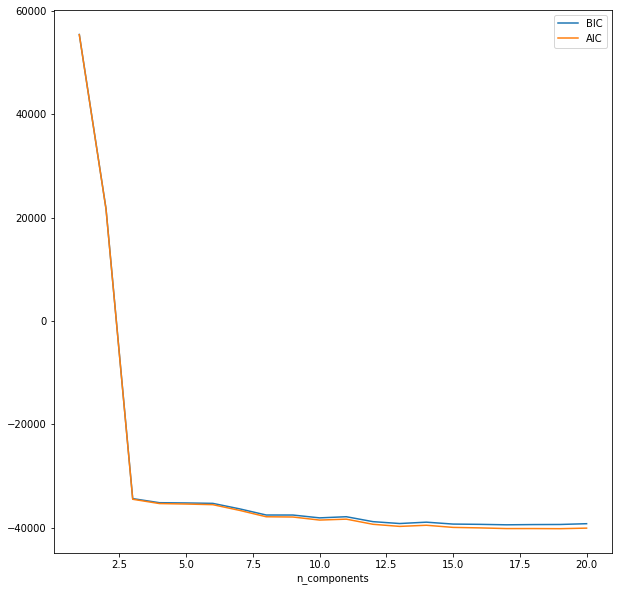

In [ ]:
# find best n_components for GMM Clustering
from sklearn.mixture import GaussianMixture

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_pca) for n in n_components]
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(n_components, [m.bic(X_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [ ]:
#define gaussian mixture model
gmm = GaussianMixture(random_state=32, n_components=3)
gmm.fit(X_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=32, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Text(0, 0.5, 'Dimension 2')

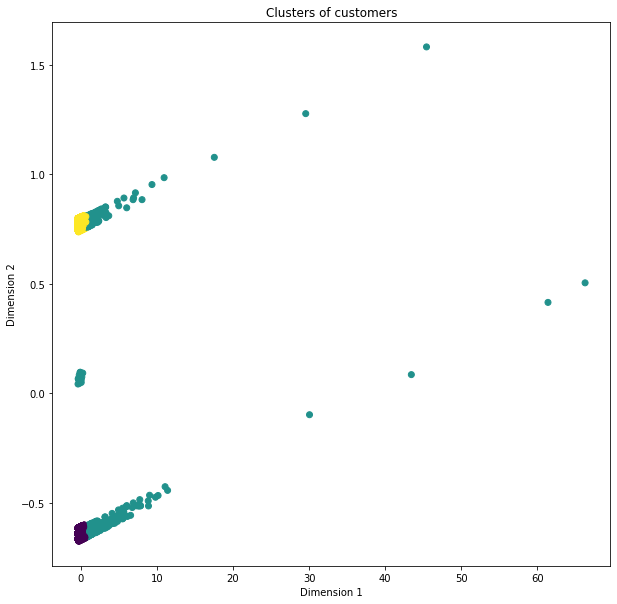

In [ ]:
# Cluster Vizualization
labels = gmm.predict(X_pca)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title('Clusters of customers')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

In [ ]:
y_ = y.flatten()
y_0 = y_[:3300]
y_0.shape

(3300,)

In [ ]:
X_pca = X_pca[:3300]
X_pca.shape

(3300, 2)

In [ ]:
from sklearn import metrics
print("ARI score: {}".format(
    metrics.adjusted_rand_score(y_0, y_pred)))

print("Silhouette score: {}".format(
    metrics.silhouette_score(X_pca, y_pred, metric='euclidean')))

ARI score: -0.013511880164689799
Silhouette score: -0.0838812105859908


#Hierarchical Clustering

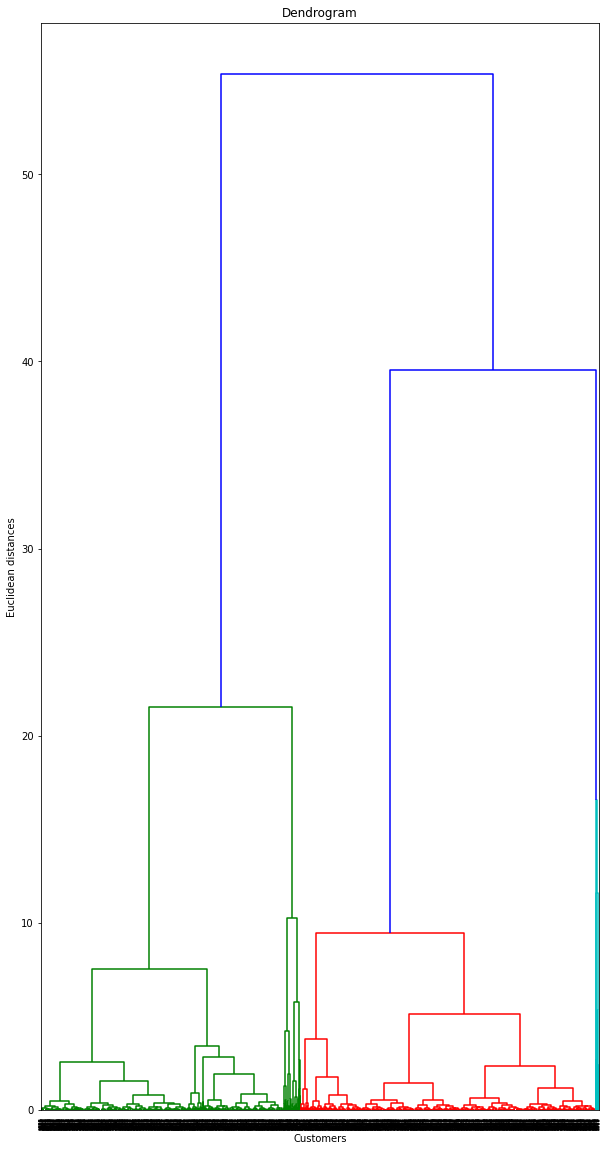

In [ ]:
# Using the dendrogram to find the optimal number of clusters
#We will use Ward’s method approach, because it does well in separating clusters if there is noise between clusters.

import scipy.cluster.hierarchy as sch
plt.rcParams["figure.figsize"] = (10,20)
dendrogram = sch.dendrogram(sch.linkage(X_pca, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

##6 can be selected as optimal cluster number


In [ ]:
# Fitting Hierarchical Clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_pca)

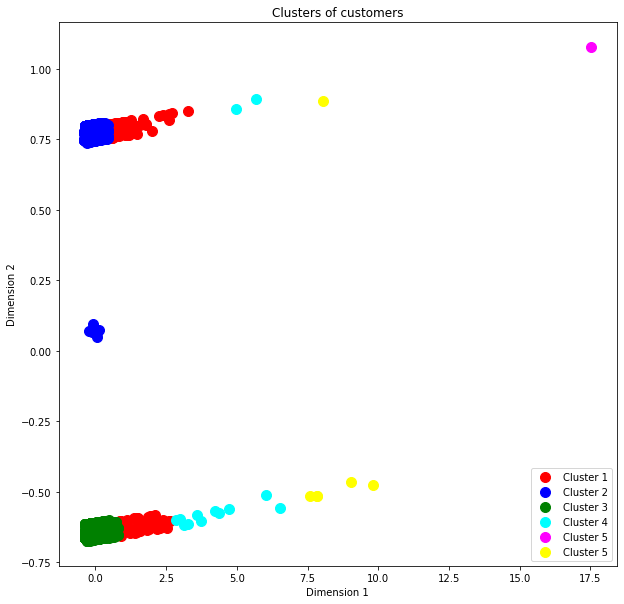

In [ ]:
# Visualising the clusters
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(X_pca[y_hc == 0, 0], X_pca[y_hc == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_pca[y_hc == 1, 0], X_pca[y_hc == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X_pca[y_hc == 2, 0], X_pca[y_hc == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X_pca[y_hc == 3, 0], X_pca[y_hc == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X_pca[y_hc == 4, 0], X_pca[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(X_pca[y_hc == 5, 0], X_pca[y_hc == 5, 1], s = 100, c = 'yellow', label = 'Cluster 5')
plt.title('Clusters of customers')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:
print("ARI score: {}".format(
    metrics.adjusted_rand_score(y_hc, y_pred)))

print("Silhouette score: {}".format(
    metrics.silhouette_score(X_pca, y_pred, metric='euclidean')))

ARI score: -0.0018522995597509092
Silhouette score: -0.0838812105859908


#Conclusion

DBSCAN - Very poor in creating visually identifiable clusters for the given dataset

GMM - Generated 3 clusters for the given dataset

Hierarchical - Generated 6 clusters for the given dataset

TSNE w/Knn - shows good separation of elements

#Final note
Although none of my models were ineffective at detecting anomalies, I did learn alot. There's not alot I can say about this data, other than the fact the highly unbalanced data is very difficult to predict without any other factor that can be used in correlation. 

##Futurework
I would try autoencoders to create meta-classifiers and bootstrap using semi-supervised learning. Also I would create a way to utilize the geo-location factor and create a scoring system that creates weights for purchases from merchants that are not local to the user. 
